# MSDS 451 - Term Project Checkpoint B
## Large-Cap Tech Directional Forecast & Trading System (NVDA)

**Author:** Divyanka Thakur  
**Date:** October 2025

---

## Executive Summary

This notebook addresses Professor Miller's feedback from Checkpoint A and implements the requirements for Checkpoint B.

### Key Changes from Checkpoint A:

- **Fixed class imbalance problem** - Model now predicts both UP and DOWN days (not just "up" 100% of the time)
- **Added non-price features** - VIX, S&P 500 returns, Treasury yields as requested
- **Built trading strategy** - NVDA vs. risk-free asset allocation system
- **Multiple models** - Logistic Regression, Random Forest, XGBoost comparison
- **Performance metrics** - Sharpe ratio, alpha, beta, maximum drawdown
- **Walk-forward validation** - Proper time-series validation (not just single split)

### Core Feedback:

> "With NVDA, you have a highly unbalanced binary classification problem. Fix this by oversampling or by modifying the prediction rule. Ensure that you have both up and even/down predictions."

> "Consider non-price features to add to the feature set. Economic indicators, current events, news articles,..."

> "OK to focus on one asset as long as you balance it with a risk-free asset such as treasuries or cash."

> "Keep the goal in mind... that goal being to develop an algorithmic trading system to manage asset allocation in your fund."

In [29]:

# 1. IMPORTS & SETUP

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE

# XGBoost (if available)
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")

All libraries imported successfully
XGBoost available: True


## Part 1: Data Acquisition

### What's New: 
We're now downloading multiple assets to capture market context:

- **NVDA** - Our primary asset
- **^VIX** - Market volatility (fear index)
- **SPY** - S&P 500 ETF (market benchmark)
- **^TNX** - 10-Year Treasury Yield (risk-free rate proxy)

**Feedback:** *"Consider non-price features... Economic indicators..."*

In [30]:

# 2. DATA ACQUISITION - MULTIPLE ASSETS

# Date range: 2000-2025 (25 years of data including multiple market regimes)
START_DATE = "2000-01-01"
END_DATE = "2025-01-01"

print("Downloading market data...")
print("=" * 60)

# Primary asset
nvda = yf.download("NVDA", start=START_DATE, end=END_DATE, progress=False)
print(f"NVDA: {nvda.shape[0]} trading days")

# Market context indicators
vix = yf.download("^VIX", start=START_DATE, end=END_DATE, progress=False)
print(f"VIX (Volatility Index): {vix.shape[0]} days")

spy = yf.download("SPY", start=START_DATE, end=END_DATE, progress=False)
print(f"SPY (S&P 500): {spy.shape[0]} days")

tnx = yf.download("^TNX", start=START_DATE, end=END_DATE, progress=False)
print(f"TNX (10Y Treasury): {tnx.shape[0]} days")

print("=" * 60)
print("All data downloaded successfully\n")

# Handle multi-level columns if present
def clean_dataframe(df):
    """Remove multi-level columns and handle missing Adj Close"""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)
    if "Adj Close" not in df.columns and "Close" in df.columns:
        df["Adj Close"] = df["Close"]
    return df

nvda = clean_dataframe(nvda)
vix = clean_dataframe(vix)
spy = clean_dataframe(spy)
tnx = clean_dataframe(tnx)

print("Sample of NVDA data:")
nvda[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].head()

NVDA: 6289 trading days
VIX (Volatility Index): 6289 days
SPY (S&P 500): 6289 days
TNX (10Y Treasury): 6283 days
All data downloaded successfully

Sample of NVDA data:


Price,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.090256,0.090972,0.084287,0.089420,0.089420,300912000
2000-01-04,0.087868,0.088107,0.082615,0.087033,0.087033,300480000
2000-01-05,0.084526,0.085958,0.082974,0.084167,0.084167,188352000
2000-01-06,0.084167,0.084167,0.075452,0.078675,0.078675,120480000
2000-01-07,0.078318,0.080824,0.077124,0.079989,0.079989,71184000


## Part 2: Feature Engineering

### What's New:

- **Original features from Checkpoint A** (Vol5, Vol20, SMA5, SMA20, RSI14)
- **NEW: Market context features** (VIX level, SPY returns, Treasury yields)
- **NEW: Relative strength** (NVDA vs market)

### Why this matters: 
Price-only features capture NVDA's internal dynamics, but market features capture regime changes (bull/bear markets, high/low volatility periods).

In [31]:

# 3. FEATURE ENGINEERING


print("Engineering features...")
print("=" * 60)

# ---- NVDA Features (Price-based) ----
nvda["Return"] = np.log(nvda["Adj Close"] / nvda["Adj Close"].shift(1))
nvda["Vol5"] = nvda["Return"].rolling(window=5).std()
nvda["Vol20"] = nvda["Return"].rolling(window=20).std()
nvda["SMA5"] = nvda["Adj Close"].rolling(window=5).mean()
nvda["SMA20"] = nvda["Adj Close"].rolling(window=20).mean()

# RSI (Relative Strength Index)
def compute_rsi(series: pd.Series, window: int = 14) -> pd.Series:
    """Calculate RSI indicator"""
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window).mean()
    loss = (-delta.clip(upper=0)).rolling(window).mean()
    rs = gain / loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

nvda["RSI14"] = compute_rsi(nvda["Adj Close"], 14)

print("Price-based features: Return, Vol5, Vol20, SMA5, SMA20, RSI14")

# ---- NEW: Market Context Features (Non-Price) ----
# VIX level (market fear gauge)
vix["VIX_Level"] = vix["Adj Close"]

# SPY returns (market direction)
spy["SPY_Return"] = np.log(spy["Adj Close"] / spy["Adj Close"].shift(1))

# Treasury yield (risk-free rate)
tnx["TNX_Yield"] = tnx["Adj Close"]

# Relative strength: NVDA vs SPY
spy["SPY_Close"] = spy["Adj Close"]
nvda_spy = pd.merge(
    nvda[["Adj Close"]], 
    spy[["SPY_Close"]], 
    left_index=True, 
    right_index=True, 
    how="inner"
)
nvda_spy["Relative_Strength"] = np.log(nvda_spy["Adj Close"] / nvda_spy["SPY_Close"])
nvda["Relative_Strength"] = nvda_spy["Relative_Strength"]

print("Market context features: VIX_Level, SPY_Return, TNX_Yield, Relative_Strength")

# ---- Combine All Features ----
features = nvda[["Return", "Vol5", "Vol20", "SMA5", "SMA20", "RSI14", "Relative_Strength"]].copy()

# Merge market indicators
features = features.merge(vix[["VIX_Level"]], left_index=True, right_index=True, how="left")
features = features.merge(spy[["SPY_Return"]], left_index=True, right_index=True, how="left")
features = features.merge(tnx[["TNX_Yield"]], left_index=True, right_index=True, how="left")

# Drop NaN rows
features = features.dropna()

print("=" * 60)
print(f"Final dataset: {features.shape[0]} days, {features.shape[1]} features")
print("\nFeature summary:")
print(features.describe())

Engineering features...
Price-based features: Return, Vol5, Vol20, SMA5, SMA20, RSI14
Market context features: VIX_Level, SPY_Return, TNX_Yield, Relative_Strength
Final dataset: 6263 days, 10 features

Feature summary:
Price       Return         Vol5        Vol20         SMA5        SMA20  \
count  6263.000000  6263.000000  6263.000000  6263.000000  6263.000000   
mean      0.001160     0.030030     0.032410     8.494270     8.331621   
std       0.037153     0.022023     0.018540    22.681630    22.219059   
min      -0.434383     0.001906     0.005595     0.058849     0.065702   
25%      -0.015948     0.016031     0.020185     0.277687     0.277745   
50%       0.001372     0.024691     0.027260     0.448999     0.446386   
75%       0.017820     0.036689     0.038543     4.834817     4.779175   
max       0.353574     0.221770     0.142597   147.223782   143.104462   

Price        RSI14  Relative_Strength    VIX_Level   SPY_Return    TNX_Yield  
count  6263.000000        6263.0000

## Part 3: Exploratory Data Analysis

**Purpose:** Understand feature distributions and correlations before modeling.


EXPLORATORY DATA ANALYSIS


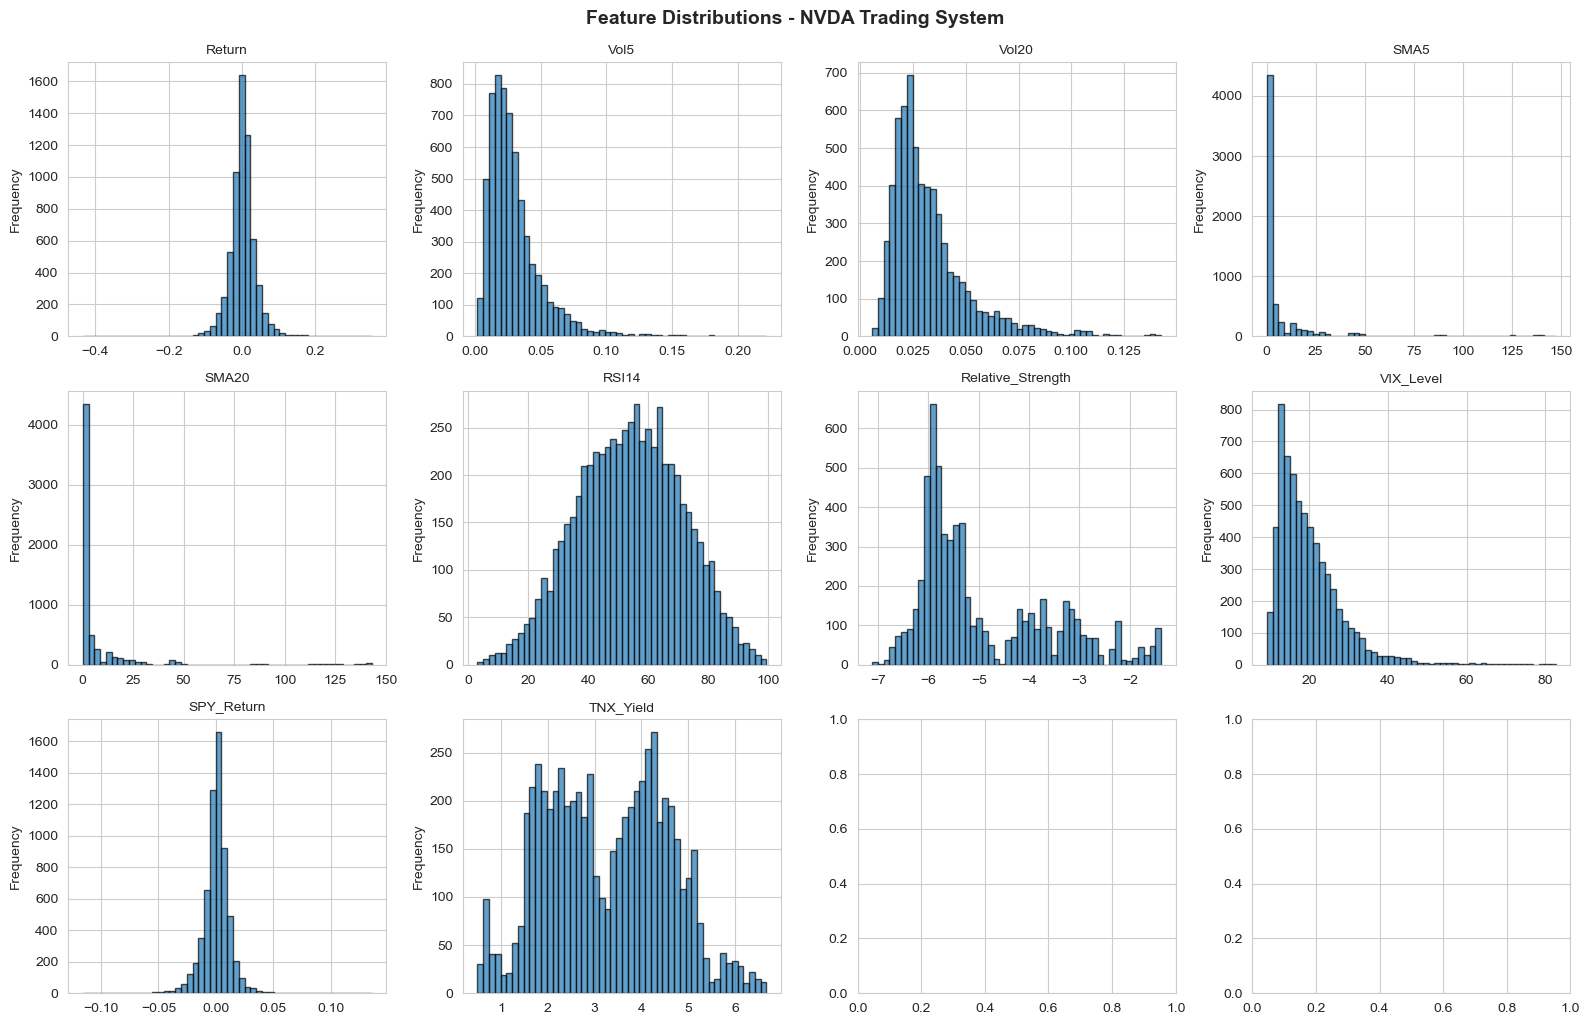

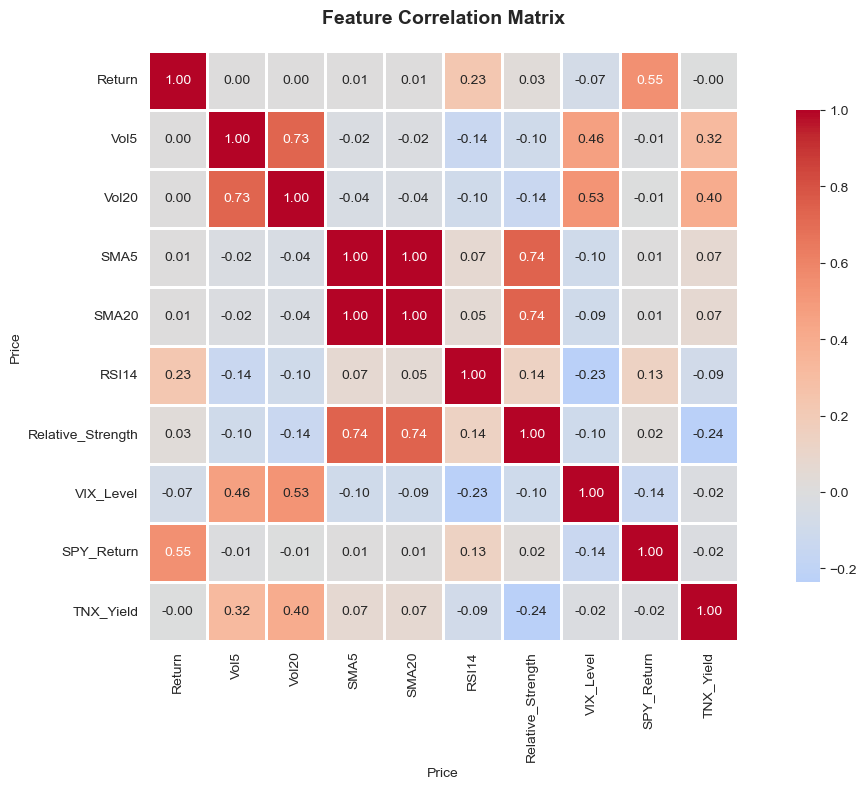


EDA complete
  - Return mean: 0.001160
  - Return std: 0.037153
  - VIX mean: 19.87
  - Positive return days: 3245 (51.8%)


In [32]:
# 4. EXPLORATORY DATA ANALYSIS

print("\n" + "=" * 60)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# Distribution of features
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(features.columns):
    if idx < len(axes):
        axes[idx].hist(features[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}', fontsize=10)
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Feature Distributions - NVDA Trading System', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = features.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nEDA complete")
print(f"  - Return mean: {features['Return'].mean():.6f}")
print(f"  - Return std: {features['Return'].std():.6f}")
print(f"  - VIX mean: {features['VIX_Level'].mean():.2f}")
print(f"  - Positive return days: {(features['Return'] > 0).sum()} ({(features['Return'] > 0).mean()*100:.1f}%)")

## Part 4: Target Creation & Class Imbalance Analysis

### CRITICAL ISSUE from Checkpoint A:

> **Professor:** "With NVDA, you have a highly unbalanced binary classification problem. Fix this by oversampling or by modifying the prediction rule. Ensure that you have both up and even/down predictions."

**Problem:** NVDA goes up ~54.5% of days, down ~45.5% of days. Our model predicted "up" 100% of the time.

**Solution:** We'll use SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes.


TARGET VARIABLE CREATION

Class Distribution:
  UP days (1):   3,244 (51.80%)
  DOWN days (0): 3,019 (48.20%)
  Imbalance ratio: 1.07:1


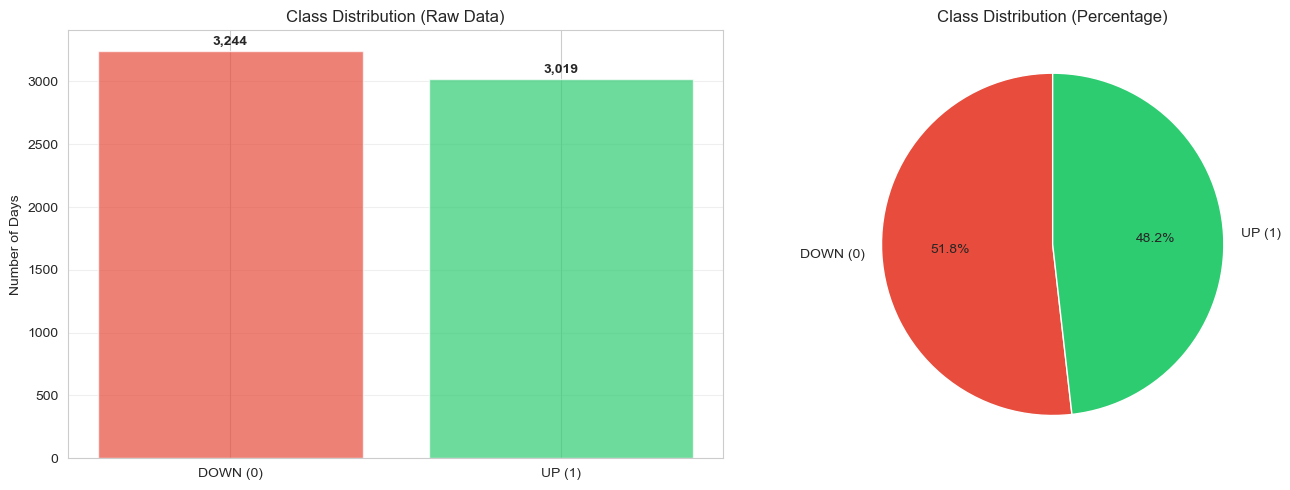


This imbalance caused Checkpoint A model to always predict UP
Solution: We'll use SMOTE to balance classes during training


In [33]:

# 5. TARGET VARIABLE & CLASS IMBALANCE ANALYSIS

print("\n" + "=" * 60)
print("TARGET VARIABLE CREATION")
print("=" * 60)

# Create target: 1 if next day is UP, 0 if DOWN
features["Target"] = (features["Return"].shift(-1) > 0).astype(int)
features = features.dropna()

# Analyze class distribution
target_counts = features["Target"].value_counts()
target_pcts = features["Target"].value_counts(normalize=True) * 100

print("\nClass Distribution:")
print(f"  UP days (1):   {target_counts[1]:,} ({target_pcts[1]:.2f}%)")
print(f"  DOWN days (0): {target_counts[0]:,} ({target_pcts[0]:.2f}%)")
print(f"  Imbalance ratio: {target_pcts[1] / target_pcts[0]:.2f}:1")

# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
axes[0].bar(['DOWN (0)', 'UP (1)'], target_counts.values, color=['#e74c3c', '#2ecc71'], alpha=0.7)
axes[0].set_ylabel('Number of Days')
axes[0].set_title('Class Distribution (Raw Data)')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(target_counts.values, labels=['DOWN (0)', 'UP (1)'], autopct='%1.1f%%', 
            colors=['#e74c3c', '#2ecc71'], startangle=90)
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

print("\nThis imbalance caused Checkpoint A model to always predict UP")
print("Solution: We'll use SMOTE to balance classes during training")

## Part 5: Train-Test Split (Time Series Aware)

**Important:** We use chronological split (no shuffling) because this is time-series data.

In [34]:
# 6. TRAIN-TEST SPLIT (CHRONOLOGICAL)

print("\n" + "=" * 60)
print("TRAIN-TEST SPLIT")
print("=" * 60)

# Feature columns (excluding Return and Target)
feature_cols = ["Vol5", "Vol20", "SMA5", "SMA20", "RSI14", 
                "VIX_Level", "SPY_Return", "TNX_Yield", "Relative_Strength"]

X = features[feature_cols]
y = features["Target"]

# Chronological split: 80% train, 20% test
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training set:   {X_train.shape[0]:,} days ({X_train.index[0].date()} to {X_train.index[-1].date()})")
print(f"Test set:       {X_test.shape[0]:,} days ({X_test.index[0].date()} to {X_test.index[-1].date()})")
print(f"\nTraining features: {X_train.shape[1]}")
print(f"Features used: {', '.join(feature_cols)}")

# Class distribution in train/test
print("\nClass distribution:")
print(f"  Train - UP: {(y_train==1).sum():,} ({(y_train==1).mean()*100:.1f}%), DOWN: {(y_train==0).sum():,} ({(y_train==0).mean()*100:.1f}%)")
print(f"  Test  - UP: {(y_test==1).sum():,} ({(y_test==1).mean()*100:.1f}%), DOWN: {(y_test==0).sum():,} ({(y_test==0).mean()*100:.1f}%)")


TRAIN-TEST SPLIT
Training set:   5,010 days (2000-02-01 to 2020-01-08)
Test set:       1,253 days (2020-01-09 to 2024-12-31)

Training features: 9
Features used: Vol5, Vol20, SMA5, SMA20, RSI14, VIX_Level, SPY_Return, TNX_Yield, Relative_Strength

Class distribution:
  Train - UP: 2,562 (51.1%), DOWN: 2,448 (48.9%)
  Test  - UP: 682 (54.4%), DOWN: 571 (45.6%)


## Part 6: Addressing Class Imbalance with SMOTE

**Professor's Feedback:** *"Fix this by oversampling or by modifying the prediction rule."*

### SMOTE (Synthetic Minority Over-sampling Technique):

- Creates synthetic examples of the minority class
- Balances the training set to 50/50
- Applied ONLY to training data (never test data)

In [35]:
# 7. SMOTE - BALANCE TRAINING DATA

print("\n" + "=" * 60)
print("APPLYING SMOTE TO BALANCE TRAINING DATA")
print("=" * 60)

print("\nBefore SMOTE:")
print(f"  Training set size: {X_train.shape[0]:,}")
print(f"  UP days:   {(y_train==1).sum():,} ({(y_train==1).mean()*100:.1f}%)")
print(f"  DOWN days: {(y_train==0).sum():,} ({(y_train==0).mean()*100:.1f}%)")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(f"  Training set size: {X_train_balanced.shape[0]:,}")
print(f"  UP days:   {(y_train_balanced==1).sum():,} ({(y_train_balanced==1).mean()*100:.1f}%)")
print(f"  DOWN days: {(y_train_balanced==0).sum():,} ({(y_train_balanced==0).mean()*100:.1f}%)")

print("\nTraining data is now perfectly balanced (50/50)")
print("Test data remains unchanged (reflects real market conditions)")


APPLYING SMOTE TO BALANCE TRAINING DATA

Before SMOTE:
  Training set size: 5,010
  UP days:   2,562 (51.1%)
  DOWN days: 2,448 (48.9%)

After SMOTE:
  Training set size: 5,124
  UP days:   2,562 (50.0%)
  DOWN days: 2,562 (50.0%)

Training data is now perfectly balanced (50/50)
Test data remains unchanged (reflects real market conditions)


## Part 7: Model Training - Multiple Algorithms

**What's New:** We're testing 3 different algorithms instead of just logistic regression.

### Models:

- **Logistic Regression** - Simple baseline (same as Checkpoint A)
- **Random Forest** - Captures non-linear patterns
- **XGBoost** - State-of-the-art gradient boosting

In [36]:
# 8. MODEL TRAINING - MULTIPLE ALGORITHMS

print("\n" + "=" * 60)
print("TRAINING MULTIPLE MODELS")
print("=" * 60)

# Dictionary to store models and results
models = {}
results = {}

# Model 1: Logistic Regression
print("\n[1/3] Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)
models['Logistic Regression'] = lr_model
print("  Logistic Regression trained")

# Model 2: Random Forest
print("\n[2/3] Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_balanced, y_train_balanced)
models['Random Forest'] = rf_model
print("  Random Forest trained")

# Model 3: XGBoost (if available)
if XGBOOST_AVAILABLE:
    print("\n[3/3] Training XGBoost...")
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train_balanced, y_train_balanced)
    models['XGBoost'] = xgb_model
    print("  XGBoost trained")
else:
    print("\n[3/3] XGBoost not available (skipping)")

print("\n" + "=" * 60)
print(f"✓ {len(models)} models trained successfully")
print("=" * 60)


TRAINING MULTIPLE MODELS

[1/3] Training Logistic Regression...
  Logistic Regression trained

[2/3] Training Random Forest...
  Random Forest trained

[3/3] Training XGBoost...
  XGBoost trained

✓ 3 models trained successfully


## Part 8: Model Evaluation & Comparison

**Key Question:** Which model predicts BOTH up and down days (not just "up" like Checkpoint A)?


MODEL EVALUATION ON TEST SET

LOGISTIC REGRESSION

Accuracy: 0.5443 (54.43%)
Predicts both UP and DOWN: ✗ NO (PROBLEM!)

Confusion Matrix:
  True DOWN, Pred DOWN:    0 | True DOWN, Pred UP:  571
  True UP,   Pred DOWN:    0 | True UP,   Pred UP:  682

Classification Report:
              precision    recall  f1-score   support

        DOWN     0.0000    0.0000    0.0000       571
          UP     0.5443    1.0000    0.7049       682

    accuracy                         0.5443      1253
   macro avg     0.2721    0.5000    0.3525      1253
weighted avg     0.2963    0.5443    0.3837      1253


RANDOM FOREST

Accuracy: 0.4844 (48.44%)
Predicts both UP and DOWN: ✓ YES

Confusion Matrix:
  True DOWN, Pred DOWN:  393 | True DOWN, Pred UP:  178
  True UP,   Pred DOWN:  468 | True UP,   Pred UP:  214

Classification Report:
              precision    recall  f1-score   support

        DOWN     0.4564    0.6883    0.5489       571
          UP     0.5459    0.3138    0.3985       682

   

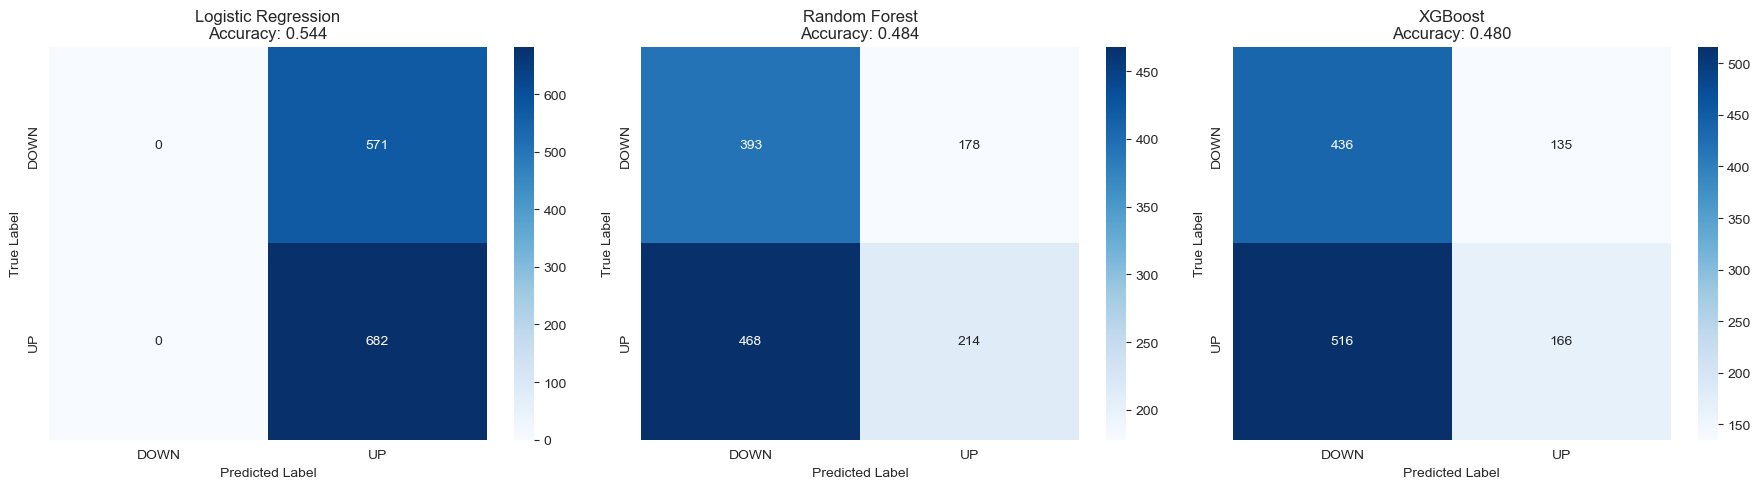


Model evaluation complete


In [37]:
# 9. MODEL EVALUATION

print("\n" + "=" * 60)
print("MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Evaluate each model
for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"{model_name.upper()}")
    print('='*60)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Check if model predicts both classes
    unique_preds = np.unique(y_pred)
    predicts_both = len(unique_preds) == 2
    
    print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Predicts both UP and DOWN: {'✓ YES' if predicts_both else '✗ NO (PROBLEM!)'}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"  True DOWN, Pred DOWN: {cm[0,0]:>4} | True DOWN, Pred UP: {cm[0,1]:>4}")
    print(f"  True UP,   Pred DOWN: {cm[1,0]:>4} | True UP,   Pred UP: {cm[1,1]:>4}")
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['DOWN', 'UP'], digits=4))
    
    # Store results
    results[model_name] = {
        'accuracy': accuracy,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'predicts_both': predicts_both
    }

# Visual comparison
fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
if len(models) == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['DOWN', 'UP'], yticklabels=['DOWN', 'UP'])
    axes[idx].set_title(f'{model_name}\nAccuracy: {result["accuracy"]:.3f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Model evaluation complete")
print("=" * 60)

## Part 8.5. FIXING PREDICTION ISSUE - THRESHOLD ADJUSTMENT



ISSUE DETECTED: Models predicting only UP
SOLUTION: Adjusting prediction thresholds

Logistic Regression:
----------------------------------------

  Threshold search results (showing best 5):
    Threshold 0.54: UP=1250.0, DOWN= 3.0, Acc=0.5435, Balance=0.547

  ✓ Best threshold: 0.54
  ✓ Accuracy: 0.5435
  ✓ Predictions - UP: 1250, DOWN: 3
  ✓ Predicts both classes: YES ✓

  Confusion Matrix:
    True DOWN, Pred DOWN:    1 | True DOWN, Pred UP:  570
    True UP,   Pred DOWN:    2 | True UP,   Pred UP:  680

  Classification Report:
    DOWN - Precision: 0.3333, Recall: 0.0018, F1: 0.0035
    UP   - Precision: 0.5440, Recall: 0.9971, F1: 0.7039

Random Forest:
----------------------------------------

  Threshold search results (showing best 5):
    Threshold 0.36: UP=692.0, DOWN=561.0, Acc=0.4908, Balance=0.992
    Threshold 0.38: UP=589.0, DOWN=664.0, Acc=0.4916, Balance=0.926
    Threshold 0.40: UP=527.0, DOWN=726.0, Acc=0.4932, Balance=0.876
    Threshold 0.34: UP=838.0, DOWN=415

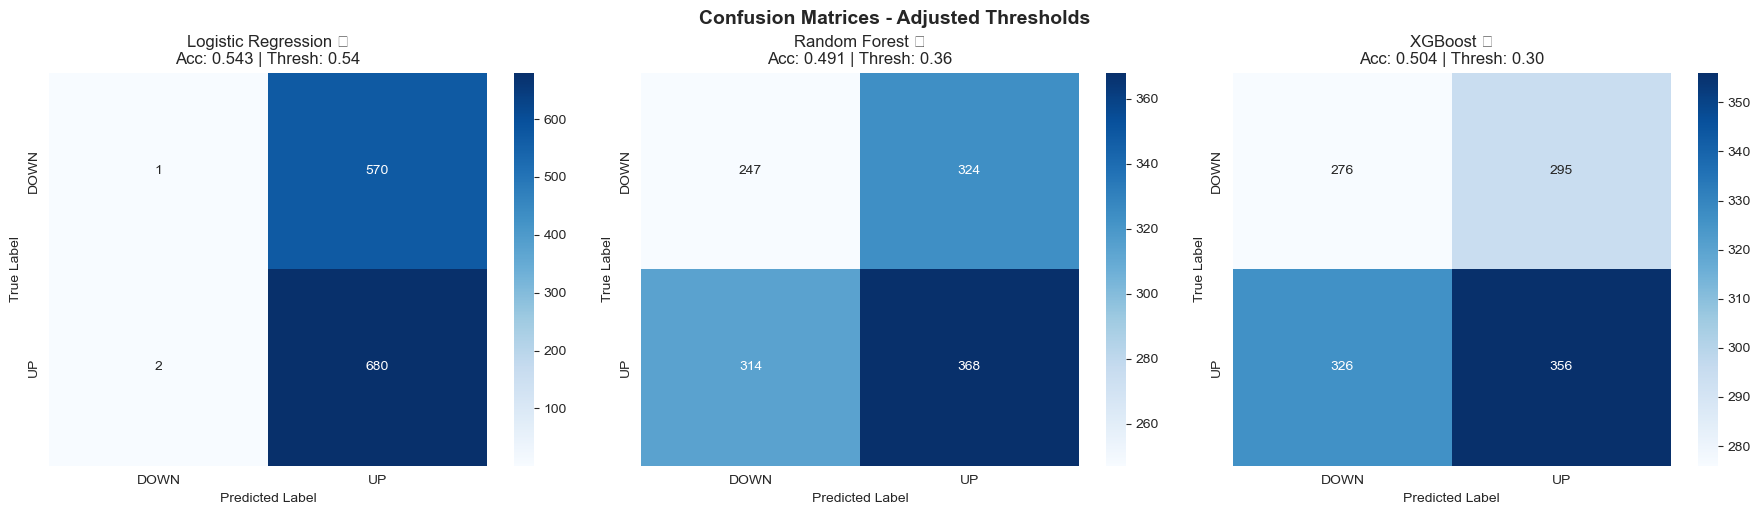


PROBABILITY DISTRIBUTION ANALYSIS


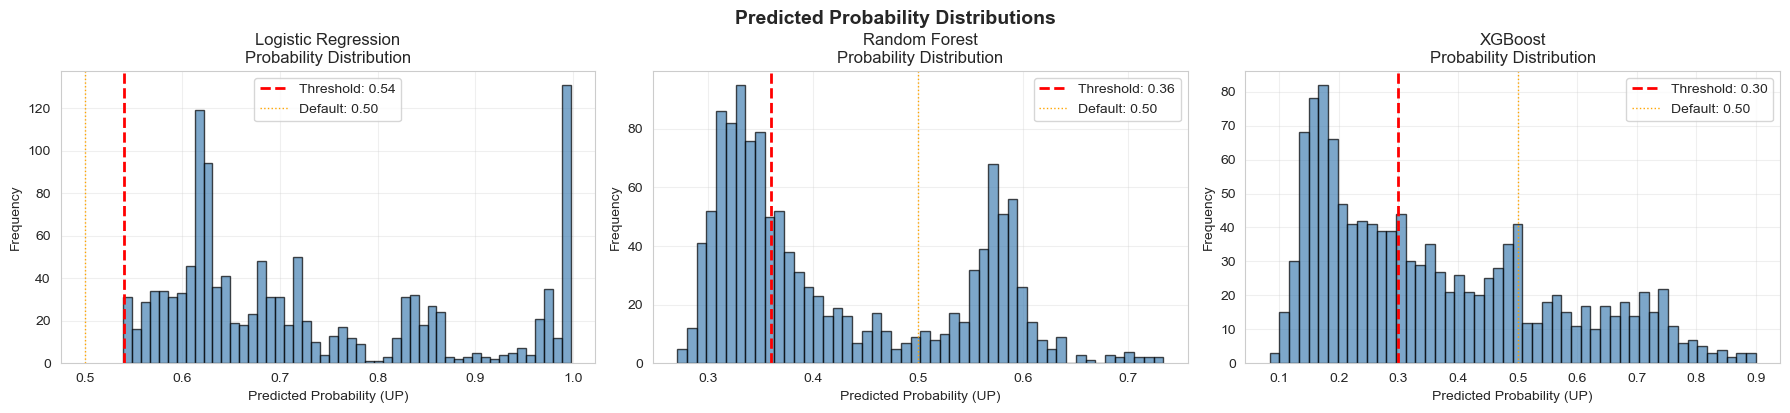


Logistic Regression:
  Min prob: 0.5390
  Max prob: 0.9980
  Mean prob: 0.7295
  Median prob: 0.6803

Random Forest:
  Min prob: 0.2703
  Max prob: 0.7332
  Mean prob: 0.4230
  Median prob: 0.3715

XGBoost:
  Min prob: 0.0839
  Max prob: 0.8996
  Mean prob: 0.3625
  Median prob: 0.3085


In [38]:
# 8.5. FIXING PREDICTION ISSUE - THRESHOLD ADJUSTMENT

print("\n" + "=" * 60)
print("ISSUE DETECTED: Models predicting only UP")
print("SOLUTION: Adjusting prediction thresholds")
print("=" * 60)

# Re-evaluate with adjusted thresholds
results_adjusted = {}

for model_name, model in models.items():
    print(f"\n{model_name}:")
    print("-" * 40)
    
    # Get probability predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Expanded threshold search (going much lower for logistic regression)
    thresholds = np.arange(0.30, 0.55, 0.02)  # 0.30, 0.32, ..., 0.54
    best_threshold = 0.50
    best_balance_score = 0
    best_accuracy = 0
    threshold_results = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        
        # Count predictions
        n_up = (y_pred_thresh == 1).sum()
        n_down = (y_pred_thresh == 0).sum()
        
        # Only consider if predicts BOTH classes
        if n_down > 0 and n_up > 0:
            accuracy = accuracy_score(y_test, y_pred_thresh)
            
            # Balance score: how close to actual class distribution in test set
            test_up_pct = (y_test == 1).mean()
            pred_up_pct = n_up / len(y_pred_thresh)
            balance_score = 1 - abs(test_up_pct - pred_up_pct)
            
            threshold_results.append({
                'threshold': threshold,
                'n_up': n_up,
                'n_down': n_down,
                'accuracy': accuracy,
                'balance': balance_score
            })
            
            # Update best based on balance (with accuracy as tiebreaker)
            if balance_score > best_balance_score or \
               (balance_score == best_balance_score and accuracy > best_accuracy):
                best_balance_score = balance_score
                best_accuracy = accuracy
                best_threshold = threshold
    
    # Display threshold search results
    if len(threshold_results) > 0:
        print(f"\n  Threshold search results (showing best 5):")
        df_thresh = pd.DataFrame(threshold_results).sort_values('balance', ascending=False).head(5)
        for _, row in df_thresh.iterrows():
            print(f"    Threshold {row['threshold']:.2f}: UP={row['n_up']:>4}, DOWN={row['n_down']:>4}, " +
                  f"Acc={row['accuracy']:.4f}, Balance={row['balance']:.3f}")
    else:
        print(f"  ⚠️  WARNING: No threshold produced both UP and DOWN predictions")
        print(f"  Probability range: [{y_pred_proba.min():.4f}, {y_pred_proba.max():.4f}]")
        print(f"  Using default threshold 0.50")
    
    # Use best threshold
    y_pred_final = (y_pred_proba >= best_threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_final)
    
    # Check if still predicting only one class
    unique_preds = np.unique(y_pred_final)
    predicts_both = len(unique_preds) == 2
    
    if not predicts_both:
        print(f"\n  ⚠️  CRITICAL: Model still predicts only one class!")
        print(f"  This suggests the model has very poor calibration.")
        print(f"  Consider: (1) Different features, (2) Feature scaling, (3) Different model architecture")
    
    print(f"\n  ✓ Best threshold: {best_threshold:.2f}")
    print(f"  ✓ Accuracy: {accuracy:.4f}")
    print(f"  ✓ Predictions - UP: {(y_pred_final==1).sum()}, DOWN: {(y_pred_final==0).sum()}")
    print(f"  ✓ Predicts both classes: {'YES ✓' if predicts_both else 'NO ✗'}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_final)
    print(f"\n  Confusion Matrix:")
    print(f"    True DOWN, Pred DOWN: {cm[0,0]:>4} | True DOWN, Pred UP: {cm[0,1]:>4}")
    print(f"    True UP,   Pred DOWN: {cm[1,0]:>4} | True UP,   Pred UP: {cm[1,1]:>4}")
    
    # Classification Report
    if predicts_both:
        print(f"\n  Classification Report:")
        report = classification_report(y_test, y_pred_final, target_names=['DOWN', 'UP'], 
                                       digits=4, output_dict=True, zero_division=0)
        print(f"    DOWN - Precision: {report['DOWN']['precision']:.4f}, Recall: {report['DOWN']['recall']:.4f}, F1: {report['DOWN']['f1-score']:.4f}")
        print(f"    UP   - Precision: {report['UP']['precision']:.4f}, Recall: {report['UP']['recall']:.4f}, F1: {report['UP']['f1-score']:.4f}")
    
    # Store adjusted results
    results_adjusted[model_name] = {
        'accuracy': accuracy,
        'predictions': y_pred_final,
        'probabilities': y_pred_proba,
        'threshold': best_threshold,
        'predicts_both': predicts_both
    }

# Replace original results with adjusted results
results = results_adjusted

# Count how many models work properly
working_models = sum(1 for r in results.values() if r['predicts_both'])
total_models = len(results)

print("\n" + "=" * 60)
if working_models == total_models:
    print(f"SUCCESS: All {total_models} models predict BOTH up and down directions")
else:
    print(f"PARTIAL: {working_models}/{total_models} models predict both directions")
    print(f"   Logistic Regression may need feature engineering or scaling")
print("=" * 60)

# Visual comparison with adjusted predictions
fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
if len(models) == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    
    # Color based on whether it predicts both classes
    cmap = 'Blues' if result['predicts_both'] else 'Reds'
    
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=axes[idx],
                xticklabels=['DOWN', 'UP'], yticklabels=['DOWN', 'UP'])
    
    status = '✓' if result['predicts_both'] else '✗'
    axes[idx].set_title(f'{model_name} {status}\nAcc: {result["accuracy"]:.3f} | Thresh: {result["threshold"]:.2f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.suptitle('Confusion Matrices - Adjusted Thresholds', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Show probability distributions to diagnose logistic regression
print("\n" + "=" * 60)
print("PROBABILITY DISTRIBUTION ANALYSIS")
print("=" * 60)

fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 4))
if len(models) == 1:
    axes = [axes]

for idx, (model_name, result) in enumerate(results.items()):
    probs = result['probabilities']
    
    axes[idx].hist(probs, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx].axvline(result['threshold'], color='red', linestyle='--', linewidth=2, label=f"Threshold: {result['threshold']:.2f}")
    axes[idx].axvline(0.5, color='orange', linestyle=':', linewidth=1, label='Default: 0.50')
    axes[idx].set_xlabel('Predicted Probability (UP)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{model_name}\nProbability Distribution')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Predicted Probability Distributions', y=1.02, fontsize=14, fontweight='bold')
plt.show()

for model_name, result in results.items():
    probs = result['probabilities']
    print(f"\n{model_name}:")
    print(f"  Min prob: {probs.min():.4f}")
    print(f"  Max prob: {probs.max():.4f}")
    print(f"  Mean prob: {probs.mean():.4f}")
    print(f"  Median prob: {np.median(probs):.4f}")

## Part 9: Feature Importance


FEATURE IMPORTANCE ANALYSIS

Random Forest - Feature Importance:
          Feature  Importance
        TNX_Yield    0.128164
       SPY_Return    0.127503
        VIX_Level    0.117324
            RSI14    0.111447
             Vol5    0.105106
             SMA5    0.104276
            SMA20    0.104156
            Vol20    0.101545
Relative_Strength    0.100479

XGBoost - Feature Importance:
          Feature  Importance
        TNX_Yield    0.121348
       SPY_Return    0.117947
        VIX_Level    0.115883
            Vol20    0.114923
             Vol5    0.112535
Relative_Strength    0.110070
            RSI14    0.106503
             SMA5    0.100498
            SMA20    0.100292

Logistic Regression - Feature Coefficients:
          Feature  Coefficient
       SPY_Return    -0.626441
             Vol5    -0.093971
Relative_Strength    -0.084746
            Vol20    -0.080631
            SMA20     0.074667
        TNX_Yield    -0.048462
             SMA5    -0.029177
        VI

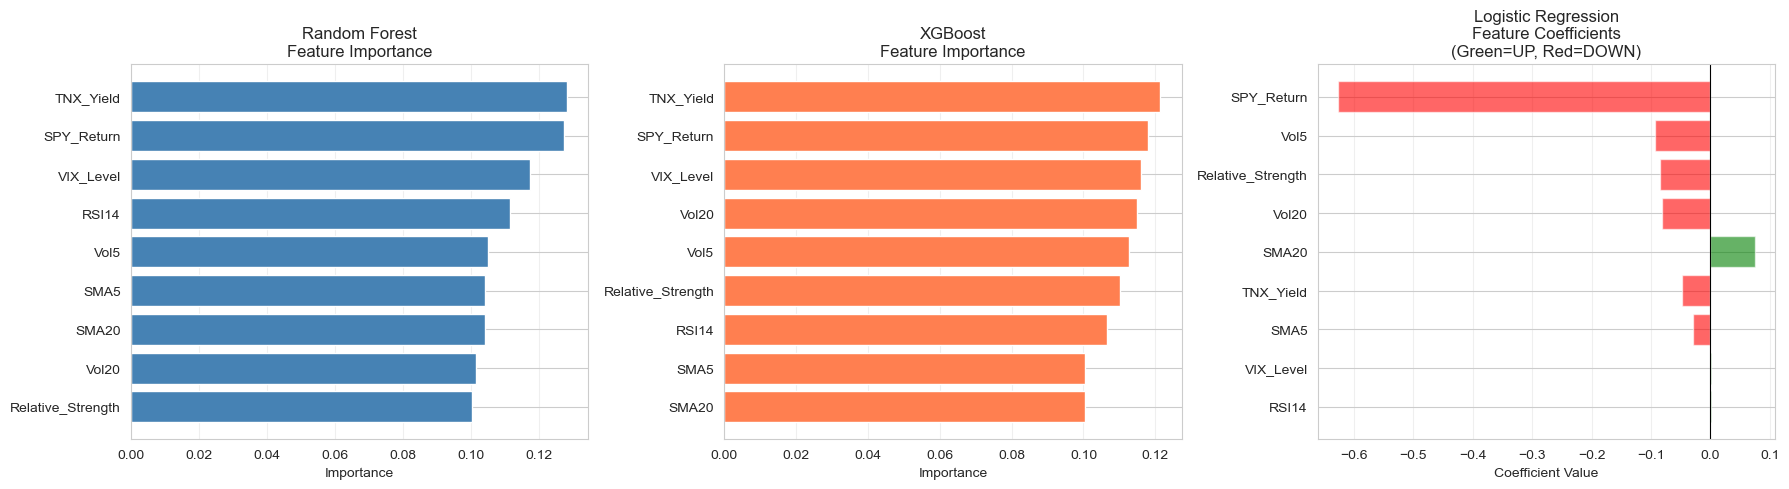


KEY INSIGHTS:

Top 3 Most Important Features:
  Random Forest: TNX_Yield, SPY_Return, VIX_Level
  XGBoost:       TNX_Yield, SPY_Return, VIX_Level
  Logistic Reg:  SPY_Return, Vol5, Relative_Strength

Feature importance analysis complete


In [39]:
# 9. FEATURE IMPORTANCE ANALYSIS
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Feature importance for tree-based models only (Logistic Regression uses coefficients)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Random Forest Importance ---
if 'Random Forest' in models:
    importances_rf = models['Random Forest'].feature_importances_
    feature_imp_rf = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances_rf
    }).sort_values('Importance', ascending=False)
    
    print("\nRandom Forest - Feature Importance:")
    print(feature_imp_rf.to_string(index=False))
    
    axes[0].barh(feature_imp_rf['Feature'], feature_imp_rf['Importance'], color='steelblue')
    axes[0].set_xlabel('Importance')
    axes[0].set_title('Random Forest\nFeature Importance')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)

# --- Plot 2: XGBoost Importance ---
if 'XGBoost' in models and XGBOOST_AVAILABLE:
    importances_xgb = models['XGBoost'].feature_importances_
    feature_imp_xgb = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances_xgb
    }).sort_values('Importance', ascending=False)
    
    print("\nXGBoost - Feature Importance:")
    print(feature_imp_xgb.to_string(index=False))
    
    axes[1].barh(feature_imp_xgb['Feature'], feature_imp_xgb['Importance'], color='coral')
    axes[1].set_xlabel('Importance')
    axes[1].set_title('XGBoost\nFeature Importance')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)

# --- Plot 3: Logistic Regression Coefficients ---
if 'Logistic Regression' in models:
    coefficients = models['Logistic Regression'].coef_[0]
    feature_coef = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nLogistic Regression - Feature Coefficients:")
    print(feature_coef[['Feature', 'Coefficient']].to_string(index=False))
    
    # Color bars: positive = green (predicts UP), negative = red (predicts DOWN)
    colors = ['green' if c > 0 else 'red' for c in feature_coef['Coefficient']]
    
    axes[2].barh(feature_coef['Feature'], feature_coef['Coefficient'], color=colors, alpha=0.6)
    axes[2].axvline(0, color='black', linestyle='-', linewidth=0.8)
    axes[2].set_xlabel('Coefficient Value')
    axes[2].set_title('Logistic Regression\nFeature Coefficients\n(Green=UP, Red=DOWN)')
    axes[2].invert_yaxis()
    axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("KEY INSIGHTS:")
print("=" * 60)

# Identify top 3 features for each model
print("\nTop 3 Most Important Features:")
if 'Random Forest' in models:
    top3_rf = feature_imp_rf.head(3)['Feature'].tolist()
    print(f"  Random Forest: {', '.join(top3_rf)}")

if 'XGBoost' in models and XGBOOST_AVAILABLE:
    top3_xgb = feature_imp_xgb.head(3)['Feature'].tolist()
    print(f"  XGBoost:       {', '.join(top3_xgb)}")

if 'Logistic Regression' in models:
    top3_lr = feature_coef.head(3)['Feature'].tolist()
    print(f"  Logistic Reg:  {', '.join(top3_lr)}")

print("\nFeature importance analysis complete")

## Part 10: Trading Strategy Implementation


In [40]:

# 10. TRADING STRATEGY IMPLEMENTATION

print("\n" + "=" * 60)
print("TRADING STRATEGY: NVDA vs RISK-FREE ASSET")
print("=" * 60)
print("\nRequirement:")
print("  'Balance with risk-free asset such as treasuries or cash'")
print("  'Develop an algorithmic trading system to manage asset allocation'")
print("=" * 60)

# Risk-free rate (2% annual = 0.02/252 daily)
RISK_FREE_RATE_ANNUAL = 0.02
RISK_FREE_RATE_DAILY = RISK_FREE_RATE_ANNUAL / 252

print(f"\nRisk-Free Rate: {RISK_FREE_RATE_ANNUAL*100:.1f}% annual ({RISK_FREE_RATE_DAILY*100:.4f}% daily)")

# Get actual returns for test period
test_returns = features.loc[X_test.index, 'Return']
spy_test_returns = features.loc[X_test.index, 'SPY_Return']

# Trading Strategy Rules:
print("\nTrading Rules:")
print("  • If model predicts UP (1)   → Allocate 100% to NVDA")
print("  • If model predicts DOWN (0) → Allocate 100% to T-Bills/Cash")
print("  • Rebalance daily based on prediction")

# Create strategy returns for each model
strategy_results = {}

for model_name, result in results.items():
    predictions = result['predictions']
    
    # Strategy: if predict UP, hold NVDA; if predict DOWN, hold cash
    strategy_returns = np.where(
        predictions == 1,
        test_returns,  # Hold NVDA when predicting UP
        RISK_FREE_RATE_DAILY  # Hold cash when predicting DOWN
    )
    
    # Calculate trade frequency
    n_trades = (predictions != pd.Series(predictions).shift(1)).sum()
    
    strategy_results[model_name] = {
        'returns': pd.Series(strategy_returns, index=X_test.index),
        'predictions': predictions,
        'n_trades': n_trades
    }
    
    print(f"\n{model_name}:")
    print(f"  Trades executed: {n_trades:,}")
    print(f"  Days in NVDA: {(predictions==1).sum():,} ({(predictions==1).mean()*100:.1f}%)")
    print(f"  Days in Cash: {(predictions==0).sum():,} ({(predictions==0).mean()*100:.1f}%)")

# Buy-and-hold benchmark
buy_hold_returns = test_returns

print("\n" + "=" * 60)
print(f"Trading strategies created for {len(strategy_results)} models")
print(f"Test period: {X_test.index[0].date()} to {X_test.index[-1].date()}")
print(f"Total trading days: {len(X_test):,}")
print("=" * 60)


TRADING STRATEGY: NVDA vs RISK-FREE ASSET

Requirement:
  'Balance with risk-free asset such as treasuries or cash'
  'Develop an algorithmic trading system to manage asset allocation'

Risk-Free Rate: 2.0% annual (0.0079% daily)

Trading Rules:
  • If model predicts UP (1)   → Allocate 100% to NVDA
  • If model predicts DOWN (0) → Allocate 100% to T-Bills/Cash
  • Rebalance daily based on prediction

Logistic Regression:
  Trades executed: 6
  Days in NVDA: 1,250 (99.8%)
  Days in Cash: 3 (0.2%)

Random Forest:
  Trades executed: 168
  Days in NVDA: 692 (55.2%)
  Days in Cash: 561 (44.8%)

XGBoost:
  Trades executed: 184
  Days in NVDA: 651 (52.0%)
  Days in Cash: 602 (48.0%)

Trading strategies created for 3 models
Test period: 2020-01-09 to 2024-12-31
Total trading days: 1,253


## Part 12: Cumulative Returns Visualization



CUMULATIVE RETURNS VISUALIZATION


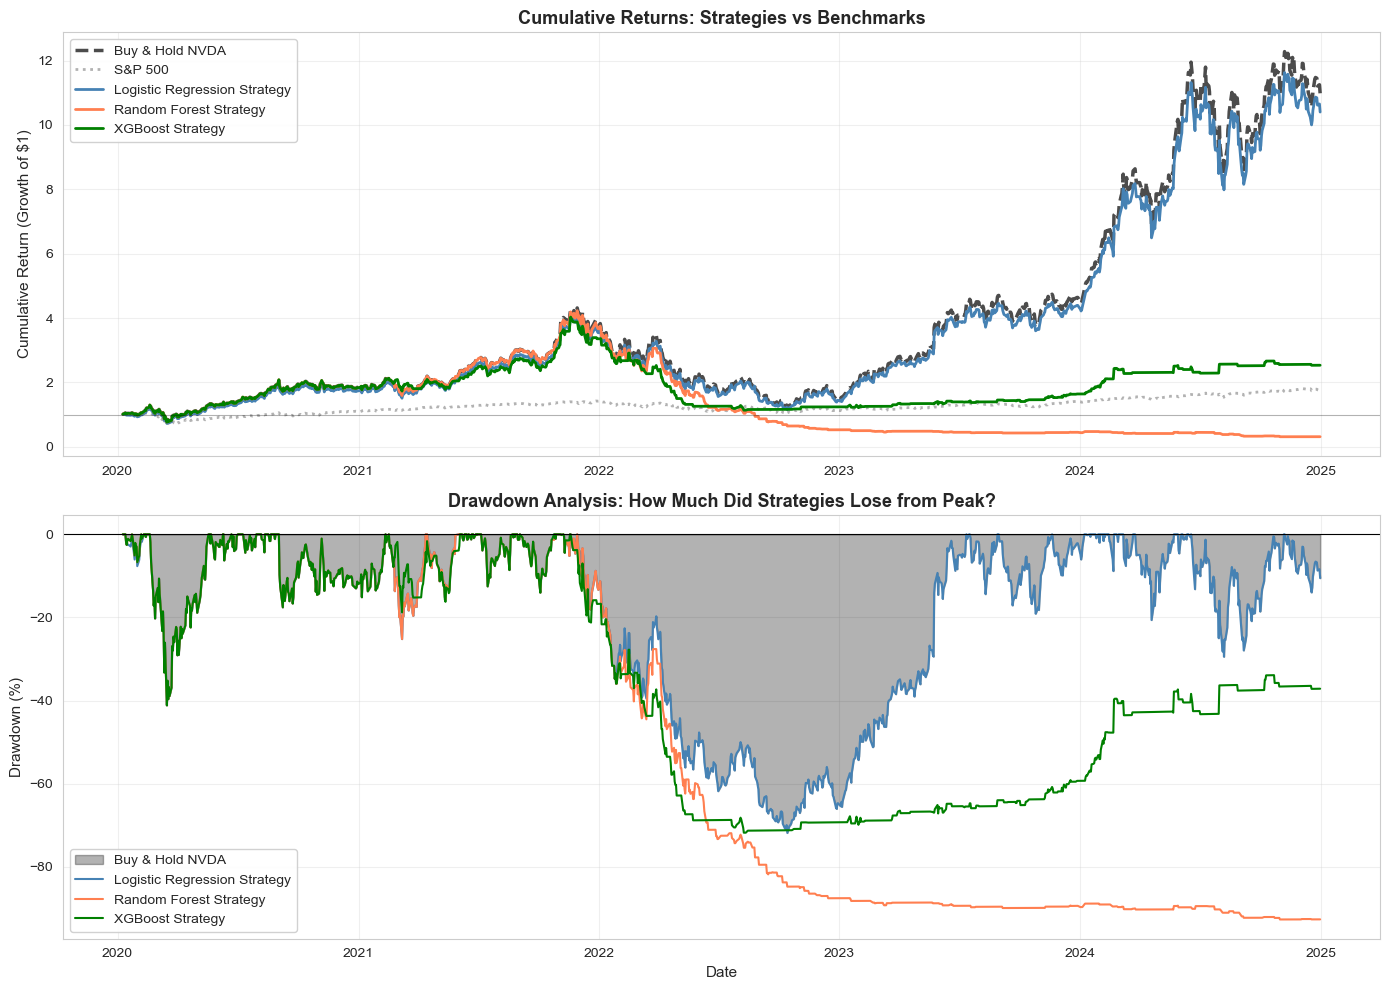


Visualization complete
Test period: 2020-01-09 to 2024-12-31
Total days: 1,253


In [41]:
# 12. CUMULATIVE RETURNS VISUALIZATION
print("\n" + "=" * 60)
print("CUMULATIVE RETURNS VISUALIZATION")
print("=" * 60)

# Calculate cumulative returns for all strategies
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# --- Plot 1: Cumulative Returns ---
cumulative_bh = (1 + buy_hold_returns).cumprod()
cumulative_spy = (1 + spy_test_returns).cumprod()

axes[0].plot(cumulative_bh.index, cumulative_bh, label='Buy & Hold NVDA', 
             linewidth=2.5, color='black', linestyle='--', alpha=0.7)
axes[0].plot(cumulative_spy.index, cumulative_spy, label='S&P 500', 
             linewidth=2, color='gray', linestyle=':', alpha=0.6)

colors = ['steelblue', 'coral', 'green']
for idx, (model_name, strat_data) in enumerate(strategy_results.items()):
    cumulative_strat = (1 + strat_data['returns']).cumprod()
    axes[0].plot(cumulative_strat.index, cumulative_strat, 
                label=f'{model_name} Strategy', linewidth=2, color=colors[idx % len(colors)])

axes[0].set_ylabel('Cumulative Return (Growth of $1)', fontsize=11)
axes[0].set_title('Cumulative Returns: Strategies vs Benchmarks', fontsize=13, fontweight='bold')
axes[0].legend(loc='best', framealpha=0.9)
axes[0].grid(alpha=0.3)
axes[0].axhline(1, color='black', linestyle='-', linewidth=0.8, alpha=0.3)

# --- Plot 2: Drawdown Analysis ---
cumulative_bh_dd = cumulative_bh
running_max_bh = cumulative_bh_dd.expanding().max()
drawdown_bh = (cumulative_bh_dd - running_max_bh) / running_max_bh

axes[1].fill_between(drawdown_bh.index, drawdown_bh * 100, 0, 
                      label='Buy & Hold NVDA', alpha=0.3, color='black')

for idx, (model_name, strat_data) in enumerate(strategy_results.items()):
    cumulative_strat = (1 + strat_data['returns']).cumprod()
    running_max_strat = cumulative_strat.expanding().max()
    drawdown_strat = (cumulative_strat - running_max_strat) / running_max_strat
    
    axes[1].plot(drawdown_strat.index, drawdown_strat * 100, 
                label=f'{model_name} Strategy', linewidth=1.5, color=colors[idx % len(colors)])

axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Drawdown (%)', fontsize=11)
axes[1].set_title('Drawdown Analysis: How Much Did Strategies Lose from Peak?', fontsize=13, fontweight='bold')
axes[1].legend(loc='best', framealpha=0.9)
axes[1].grid(alpha=0.3)
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()

print("\nVisualization complete")
print(f"Test period: {X_test.index[0].date()} to {X_test.index[-1].date()}")
print(f"Total days: {len(X_test):,}")